In [3]:
from src.intrinsic.nn.loss.functional import signature_loss
import torch

In [4]:
class LinearAutoencoder(torch.nn.Module):
    """Simple linear autoencoder class.

    This module performs simple embeddings based on an MSE loss. This is
    similar to ordinary principal component analysis. Notice that the
    class is only meant to provide a simple example that can be run
    easily even without the availability of a GPU. In practice, there
    are many more architectures with improved expressive power
    available.
    """

    def __init__(self, input_dim, latent_dim=2):
        """Create new autoencoder with pre-defined latent dimension."""
        super().__init__()

        self.input_dim = input_dim
        self.latent_dim = latent_dim

        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(self.input_dim, self.latent_dim)
        )

        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(self.latent_dim, self.input_dim)
        )

        self.loss_fn = torch.nn.MSELoss()

    def encode(self, x):
        """Embed data in latent space."""
        return self.encoder(x)

    def decode(self, z):
        """Decode data from latent space."""
        return self.decoder(z)

    def forward(self, x):
        """Embeds and reconstructs data, returning a loss."""
        z = self.encode(x)
        x_hat = self.decode(z)

        # The loss can of course be changed. If this is your first time
        # working with autoencoders, a good exercise would be to 'grok'
        # the meaning of different losses.
        reconstruction_error = self.loss_fn(x, x_hat)
        return reconstruction_error

In [5]:
class TopologicalAutoencoder(torch.nn.Module):
    """Wrapper for a topologically-regularised autoencoder.

    This class uses another autoencoder model and imbues it with an
    additional topology-based loss term.
    """
    def __init__(self, model, lam=1.0):
        super().__init__()

        self.lam = lam
        self.model = model

    def forward(self, x):
        z = self.model.encode(x)

        geom_loss = self.model(x)
        topo_loss = signature_loss(x, z)

        loss = geom_loss + self.lam * topo_loss
        return loss

In [6]:
import torch
import torch.optim as optim

import matplotlib.pyplot as plt

from tqdm import tqdm

from torch.utils.data import DataLoader

from torch_topological.datasets import Spheres

In [11]:
from src.intrinsic.nn.loss.vr import VietorisRips

In [21]:
def signature_loss(X: torch.Tensor, Z: torch.Tensor):  # FIXME
    X, Z = X.unsqueeze(0), Z.unsqueeze(0)
    _, gens_tensorXd = VietorisRips.apply(X)[2:]
    _, gens_tensorZd = VietorisRips.apply(Z)[2:]
    distXX = torch.norm(batch_select(X, gens_tensorXd[:, :, :, 1]) - batch_select(X, gens_tensorXd[:, :, :, 0]))
    distZX = torch.norm(batch_select(Z, gens_tensorXd[:, :, :, 1]) - batch_select(Z, gens_tensorXd[:, :, :, 0]))
    distZZ = torch.norm(batch_select(Z, gens_tensorZd[:, :, :, 1]) - batch_select(Z, gens_tensorZd[:, :, :, 0]))
    distXZ = torch.norm(batch_select(X, gens_tensorZd[:, :, :, 1]) - batch_select(X, gens_tensorZd[:, :, :, 0]))

    return torch.sqrt(torch.square(distXX - distZX).sum()) / 2 + torch.sqrt(torch.square(distXZ - distZZ).sum()) / 2

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.52it/s, loss=27.1]


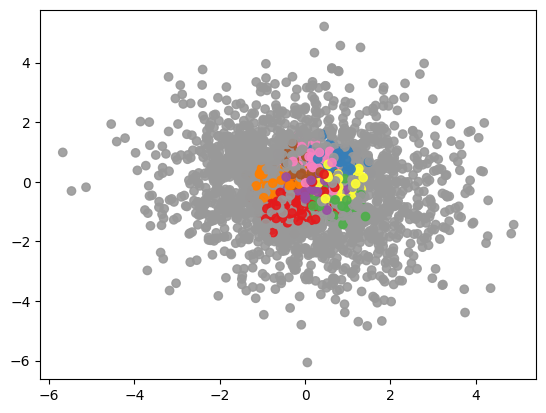

In [22]:
n_spheres = 11
data_set = Spheres(n_spheres=n_spheres)

train_loader = DataLoader(
    data_set,
    batch_size=32,
    shuffle=True,
    drop_last=True
)

# Let's set up the two models that we are training. Note that in
# a real application, you would have a more complicated training
# setup, potentially with early stopping etc. This training loop
# is merely to be seen as a proof of concept.
model = LinearAutoencoder(input_dim=data_set.dimension)
topo_model = TopologicalAutoencoder(model, lam=10)

optimizer = optim.Adam(topo_model.parameters(), lr=1e-3)

n_epochs = 5

progress = tqdm(range(n_epochs))

for i in progress:
    topo_model.train()

    for batch, (x, y) in enumerate(train_loader):
        loss = topo_model(x)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    progress.set_postfix(loss=loss.item())

# Evaluate the autoencoder on a new instance of the data set.
data_set = Spheres(
    train=False,
    n_samples=2000,
    n_spheres=n_spheres,
)

test_loader = DataLoader(
        data_set,
        shuffle=False,
        batch_size=len(data_set)
)

X, y = next(iter(test_loader))
Z = topo_model.model.encode(X).detach().numpy()

plt.scatter(
    Z[:, 0], Z[:, 1],
    c=y,
    cmap='Set1',
    marker='o',
    alpha=0.9,
)
plt.show()

In [23]:
X, y = next(iter(train_loader))
X.shape, y.shape

(torch.Size([32, 101]), torch.Size([32]))

In [24]:
y

tensor([ 0.,  9.,  0., 10., 10., 10., 10., 10.,  8., 10., 10.,  8., 10.,  6.,
        10.,  1., 10., 10., 10.,  2., 10.,  8.,  4.,  8.,  2., 10., 10.,  2.,
         0.,  2., 10., 10.], dtype=torch.float64)

In [19]:
X

tensor([[ 3.0497,  4.1139, -1.2326,  ...,  2.6777, -1.5895,  5.8849],
        [ 1.3681, -1.7717, -2.6236,  ...,  2.8485,  0.1377,  3.2550],
        [ 1.0335, -3.0620, -3.6575,  ..., -4.2352, -1.4446, -0.9437],
        ...,
        [-1.7743,  1.0885,  0.8090,  ...,  1.8154,  0.2053, -1.1467],
        [-0.2500,  1.4547,  0.2814,  ...,  0.0131, -0.6974, -0.4581],
        [ 0.9445,  1.2074,  0.4631,  ...,  0.4363,  0.7331, -2.2493]])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.73it/s, loss=28.3]


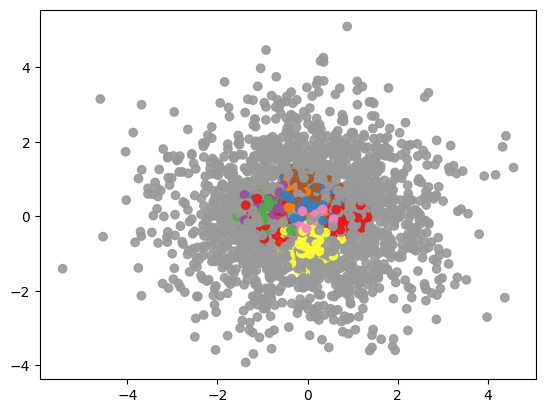

In [20]:
"""Demo for topology-regularised autoencoders.

This example demonstrates how to use `pytorch-topological` to create an
additional differentiable loss term that makes autoencoders aware of
topological features. See [Moor20a]_ for more information.
"""

import torch
import torch.optim as optim

import matplotlib.pyplot as plt

from tqdm import tqdm

from torch.utils.data import DataLoader

from torch_topological.datasets import Spheres

from torch_topological.nn import SignatureLoss
from torch_topological.nn import VietorisRipsComplex


class LinearAutoencoder(torch.nn.Module):
    """Simple linear autoencoder class.

    This module performs simple embeddings based on an MSE loss. This is
    similar to ordinary principal component analysis. Notice that the
    class is only meant to provide a simple example that can be run
    easily even without the availability of a GPU. In practice, there
    are many more architectures with improved expressive power
    available.
    """

    def __init__(self, input_dim, latent_dim=2):
        """Create new autoencoder with pre-defined latent dimension."""
        super().__init__()

        self.input_dim = input_dim
        self.latent_dim = latent_dim

        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(self.input_dim, self.latent_dim)
        )

        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(self.latent_dim, self.input_dim)
        )

        self.loss_fn = torch.nn.MSELoss()

    def encode(self, x):
        """Embed data in latent space."""
        return self.encoder(x)

    def decode(self, z):
        """Decode data from latent space."""
        return self.decoder(z)

    def forward(self, x):
        """Embeds and reconstructs data, returning a loss."""
        z = self.encode(x)
        x_hat = self.decode(z)

        # The loss can of course be changed. If this is your first time
        # working with autoencoders, a good exercise would be to 'grok'
        # the meaning of different losses.
        reconstruction_error = self.loss_fn(x, x_hat)
        return reconstruction_error


class TopologicalAutoencoder(torch.nn.Module):
    """Wrapper for a topologically-regularised autoencoder.

    This class uses another autoencoder model and imbues it with an
    additional topology-based loss term.
    """
    def __init__(self, model, lam=1.0):
        super().__init__()

        self.lam = lam
        self.model = model
        self.loss = SignatureLoss(p=2)

        # TODO: Make dimensionality configurable
        self.vr = VietorisRipsComplex(dim=0)

    def forward(self, x):
        z = self.model.encode(x)

        pi_x = self.vr(x)
        pi_z = self.vr(z)

        geom_loss = self.model(x)
        topo_loss = self.loss([x, pi_x], [z, pi_z])

        loss = geom_loss + self.lam * topo_loss
        return loss


# We first have to create a data set. This follows the original
# publication by Moor et al. by introducing a simple 'manifold'
# data set consisting of multiple spheres.
n_spheres = 11
data_set = Spheres(n_spheres=n_spheres)

train_loader = DataLoader(
    data_set,
    batch_size=32,
    shuffle=True,
    drop_last=True
)

# Let's set up the two models that we are training. Note that in
# a real application, you would have a more complicated training
# setup, potentially with early stopping etc. This training loop
# is merely to be seen as a proof of concept.
model = LinearAutoencoder(input_dim=data_set.dimension)
topo_model = TopologicalAutoencoder(model, lam=10)

optimizer = optim.Adam(topo_model.parameters(), lr=1e-3)

n_epochs = 5

progress = tqdm(range(n_epochs))

for i in progress:
    topo_model.train()

    for batch, (x, y) in enumerate(train_loader):
        loss = topo_model(x)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    progress.set_postfix(loss=loss.item())

# Evaluate the autoencoder on a new instance of the data set.
data_set = Spheres(
    train=False,
    n_samples=2000,
    n_spheres=n_spheres,
)

test_loader = DataLoader(
        data_set,
        shuffle=False,
        batch_size=len(data_set)
)

X, y = next(iter(test_loader))
Z = topo_model.model.encode(X).detach().numpy()

plt.scatter(
    Z[:, 0], Z[:, 1],
    c=y,
    cmap='Set1',
    marker='o',
    alpha=0.9,
)
plt.show()